In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [46]:
# the expected_size and threshold parameters define an expectation around the size of returns samples 
# to avoid dealing with incomplete price data/etc
def calculate_daily_returns(data, tickers, expected_size=252, threshold=20):
    returns = pd.DataFrame()
    for ticker in tickers:
        stock = data[data["TICKER"]==ticker]
        if not stock.empty:
            stock = stock[~stock.index.duplicated(keep='first')] # remove duplicates for a date
            stock = stock.fillna(0) #if returns are missing just set to zero
            rows = len(stock.index)
            if rows >= expected_size - threshold and rows <= expected_size + threshold:
                returns = pd.concat([returns, stock["RET"].rename(ticker)], axis=1, join='outer')
    return returns.fillna(0)

def calculate_residuals(stock_returns, factor_returns, num_components):
    residuals = pd.DataFrame(columns = stock_returns.columns, index = stock_returns.index)
    betas = pd.DataFrame(columns = stock_returns.columns, index = range(num_components))
    ols = LinearRegression()
    for ticker in stock_returns.columns:
        ols.fit(factor_returns.iloc[:, 0:num_components], stock_returns[ticker])
        fitted_returns = ols.intercept_ + np.dot(factor_returns.iloc[:, 0:num_components], ols.coef_)
        residuals[ticker] = stock_returns[ticker] - fitted_returns
        betas[ticker] = ols.coef_
    return residuals, betas

#reference: 
#https://commoditymodels.files.wordpress.com/2010/02/
#estimating-the-parameters-of-a-mean-reverting-ornstein-uhlenbeck-process1.pdf
def calculate_s_score(residuals, mean_reversion_speed_thresh):
    m = pd.Series()
    sigma_eq = pd.Series()
    for ticker in residuals.columns:
        stock_res = residuals[ticker]
        x_k = stock_res.cumsum()
        x_lag = x_k.shift(1)
        x_lag[0] = 0
        
        #run OLS regression to find b ==> kappa
        ols = LinearRegression(fit_intercept=True)
        ols.fit(x_lag.values.reshape(-1,1), x_k)
        b = ols.coef_[0]
        kappa = -np.log(b)*252

        #select only the stocks with fast mean reversion i.e. speed larger than the threshold
        if kappa >= mean_reversion_speed_thresh:
            a = ols.intercept_
            m[ticker] = a/(1-b)
            residual = (x_k - ols.predict(x_lag.values.reshape(-1,1)))
            sigma_eq[ticker] = np.std(residual)*np.sqrt(1/(1-b*b) )
    m = m.dropna()
    m = m - m.mean()
    sigma_eq = sigma_eq.dropna()
    s_score = -m/sigma_eq
    return s_score

In [47]:
# Use the PCA results from previous year and regress against the returns of this year 
# to find residuals.
year = 2012

# load data
eigen_portfolios = pd.read_pickle(f"./eigen_{year-1}.pkl")
betas = pd.read_pickle(f"./betas_{year-1}.pkl")
data = pd.read_pickle(f"./data_{year}.pkl")
data = data.set_index("date")
# ensure return data is numeric
data["RET"] = pd.to_numeric(data["RET"], errors='coerce')


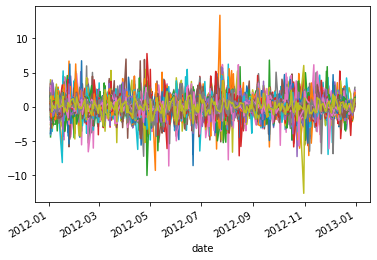

In [48]:
# calculate returns for this year
returns = calculate_daily_returns(data, betas.columns.tolist())
std_returns = (returns - returns.mean(axis=0))/returns.std(axis = 0)
std_returns.plot(legend=False)

In [11]:
universe = std_returns.columns.intersection(eigen_portfolios.columns)
std_returns = std_returns[universe]
eigen_portfolios = eigen_portfolios[universe]

In [49]:
eigen_portfolios

ABT       AET       AEM       APD       HON       HES        AEP  \
0   -5.160091 -2.741598 -0.811604 -4.001544 -3.516913 -2.578341  -4.911862   
1  -10.250342 -1.282575  4.580728  1.474596  0.332348  3.278632  -9.022383   
2   -3.350099  2.150160 -6.114531 -0.142538  2.077551 -2.291390  -8.521436   
3   -5.527057 -0.358987 -6.282827  0.349037  0.172137  1.656522  -0.377969   
4   -2.791248  1.423222 -6.539773 -2.220318 -0.532886  1.026785   3.378512   
5   -9.020925 -0.860995  8.941904 -1.582539 -2.791250 -2.874477   6.867265   
6    2.210987  4.343257  1.292525  0.831636  1.755342 -1.786069 -11.713440   
7   -6.046817 -2.857329  0.372822 -2.243913 -1.728318  2.166853   0.967996   
8   -0.606045  3.880826  0.091563  2.269798 -1.568240 -0.034007   2.937652   
9   -6.312017  0.290042  1.680166  0.745310 -0.211458  0.343243  -0.539218   
10   4.215372  1.898783 -2.686858  1.456782  1.976918  1.578444   2.539430   
11   0.579036 -1.285526 -1.955759 -3.284257 -2.449074 -0.386510  -5.814107   
12   6.259766 -1.774864 -2.365472 -1.630530 -1.144666 -0.035287   3.867009   
13  -2.512108 -2.137441 -2.207934  2.809031 -0.567471  0.066897  -2.600769   
14  -4.363610  3.944165  1.303178 -0.626740 -1.160339 -0.124795   1.512443   
15   3.306441  4.425234 -1.070802  0.919134  0.125834 -0.464025  -0.968883   
16  -2.379457  0.039756 -3.098626 -2.457778 -2.815026 -0.732615   9.009259   
17   2.206702  4.426123 -3.649049  0.637779 -2.066264  0.324628   0.407953   
18 -10.354815  0.659266 -1.785794 -3.533071  0.331598  0.583630  -1.577178   
19  -0.699351  4.747701  1.562490 -2.669832  4.626021 -0.630298   6.130753   
20   0.026303  0.385951  1.092623  1.988635 -1.098698  2.227607  -3.514049   
21  -4.425467  2.775020 -2.530433  1.564776  2.417349  0.297102   2.991827   
22  -2.208480  0.185822  0.419417 -1.286371  0.233374 -1.325814  -0.233023   
23  -3.910711 -0.509207  1.856978  3.477777 -1.868081 -2.364652   1.110610   
24   2.691339  1.310350 -0.122021  5.507310  2.473856 -1.446197  -0.570562   
25  -3.144092  5.778019 -1.463486 -0.814573 -1.318301  1.948226  -2.470081   
26  -0.513909  1.660423  0.929799  0.296371 -0.490293 -0.742289   1.244643   
27   2.355255 -3.008801 -0.384781 -1.745900  1.527330 -0.690788   5.740631   
28   7.559687 -7.823820 -0.487077  0.375479  1.442607 -0.753584  -1.236182   
29  -4.942959 -3.335005 -1.053188  4.218835  1.411764  0.341357   2.470542   
30   4.230924  0.666221  1.654111  1.974163  1.905304  3.016719  -2.467863   
31  -2.226806  3.169977 -0.202413  2.809081 -0.451081 -1.075968  -0.081819   
32  -8.056212  1.677779  2.570957 -1.931543 -0.534986  0.940462  -1.728441   
33   5.467867  3.512786 -0.734271  1.619945  1.386810  0.127005   0.659810   
34   2.970493  1.668605 -1.840393 -4.439498 -1.682775 -0.812011   3.028163   
35   4.882333  0.782039 -0.906440 -0.301749  3.411806  0.882258   1.747496   
36  -3.265435  0.489271 -1.963096 -0.376609 -3.083095 -0.900824   2.141817   
37  -2.581450 -5.386131  3.542883  1.682182  0.547635 -1.576026   4.976414   
38  -0.712632 -0.891699  0.392731  0.624383  2.375834 -0.907439  -3.331655   
39   6.716703 -2.977972 -0.161298 -1.888719 -0.213111  0.747225   3.586949   
40  14.113907 -1.315112  0.801107 -1.564729 -2.790463 -2.391550  -0.863888   
41  -9.096000  3.895123  2.664223 -0.594684  1.907114  0.529186  -9.034623   
42  -2.523353 -1.626667  1.067054  1.728485  3.218235 -1.284767  -0.838675   
43   0.905256  4.167451  5.175165  1.680734 -1.356176 -0.576982   4.596097   
44   0.995528 -1.399090 -2.367305  5.290975 -0.103661  3.363263   4.274880   
45  -9.502035  9.034659  1.415868 -4.092271  0.063530  3.819219  -2.391905   
46   7.246118  4.645140 -2.902048 -1.712953  3.124813  0.288714  -2.562056   
47   3.095166  4.658184 -0.945540 -2.621144 -2.751331 -0.261867   2.451438   
48  -4.983671  0.257456 -2.621158  0.522724  5.271199 -0.034856   6.037699   
49   3.283676 -2.049641  3.442832 -2.253277  1.361103 -2.507171  -2.114314   

         AXP       AMGN       A

In [13]:
#calculate residuals
# match the columns to the stocks chosen last year

factor_returns = pd.DataFrame(np.dot(std_returns, eigen_portfolios.transpose()),index = std_returns.index)
factor_returns

0           1           2           3           4   \
date                                                                      
2012-01-03  -626.426527  750.171559  252.972085  178.621978 -309.266699   
2012-01-04   131.424757  262.849934  163.037214   32.656020   60.180751   
2012-01-05   -39.028079   61.303461  115.989991   19.181370   80.468380   
2012-01-06   260.024370  165.047617  315.945819  -44.900130  -81.280365   
2012-01-09  -170.760466   11.044895  -22.121123   76.783802 -107.294983   
2012-01-10  -610.754828    7.697632   21.927325    5.340691 -113.976674   
2012-01-11    70.488354   47.540437  299.131070   36.178127  -91.778977   
2012-01-12  -202.277060  -18.746396  149.411751  -16.586524 -121.139611   
2012-01-13   351.123121   19.595912   -5.113587    9.477518  114.613827   
2012-01-17  -249.732058  -30.680599  -36.218456  -78.582386  205.414275   
2012-01-18  -591.841287  116.763811  178.587240 -118.829960  -43.557928   
2012-01-19  -285.078655  173.687912  365.801895   66.913277 -145.685356   
2012-01-20    -0.462472  -39.108598  -73.894717   -8.665589   92.358683   
2012-01-23   -49.050450  213.987358 -195.989265  137.024118  194.062450   
2012-01-24   267.948060  244.297875  423.852344  -57.706602  -33.435277   
2012-01-25  -613.263448 -231.128513 -440.855260 -242.963364  118.046474   
2012-01-26   301.646879  -58.472330  -52.480999  -61.203680    6.161090   
2012-01-27   313.989267  519.378592  306.836841   31.458162 -149.273958   
2012-01-30   283.825234   71.792502   94.688462  -50.353843   43.085420   
2012-01-31   -14.131899  -99.787701  -90.747893  -13.309643  135.456333   
2012-02-01  -593.314093 -127.872155   18.334122   52.403866   58.788606   
2012-02-02     5.144315   67.328549   20.648587  -27.331998  -67.425864   
2012-02-03  -776.904980  -24.516324  179.550933  190.348505  -30.646373   
2012-02-06   195.592637  117.322075  -42.709539  -15.042613   22.858391   
2012-02-07   -76.801475 -163.528100 -141.964835  -11.561072  134.475429   
2012-02-08    -7.143479   29.659652   82.986129   77.952667   -5.903975   
2012-02-09    67.928422   79.353060   76.104485  -83.605738   33.416714   
2012-02-10   553.394755   -7.063007   44.818104    5.920566  108.697114   
2012-02-13  -310.624718   -0.338503   47.231569  -19.305023   39.827317   
2012-02-14    59.042185 -112.507446  -80.964409 -134.801125   92.669398   
...                 ...         ...         ...         ...         ...   
2012-11-16  -406.705143 -249.893427 -307.637830 -135.158513  417.803976   
2012-11-19 -1010.514682 -136.079432  -93.209207 -202.538790  -67.024591   
2012-11-20     9.111045  -35.268013    4.295164   -8.224633    4.413293   
2012-11-21   -92.137727   63.230777   39.041550  -93.343637  -23.836112   
2012-11-23  -769.043324 -128.021527    5.251216 -180.530100 -153.346128   
2012-11-26   131.375498 -149.725943 -107.934481   53.805998   99.283277   
2012-11-27   273.929972  -33.108658   44.552489   45.948284   68.351693   
2012-11-28  -506.229119 -222.726351  -41.043087 -176.619661   34.970925   
2012-11-29  -287.816097 -117.942772  -97.344818    5.477068   23.182131   
2012-11-30   -72.878099 -304.057752 -204.361883  -15.523980   45.423325   
2012-12-03   412.327794  172.298651  132.801593   47.610389  -14.590275   
2012-12-04   122.444855  136.353612  193.179624   -8.876013 -169.281452   
2012-12-05  -385.450611 -379.331006 -262.116297  211.908289   80.100677   
2012-12-06  -100.439302   25.264763   57.116645  -61.388567  -32.730913   
2012-12-07  -224.265946 -137.240792  -81.024200  -49.386051  -50.498862   
2012-12-10   -81.264152   64.834483   -2.531521  -29.381615   34.490051   
2012-12-11  -322.176469  -27.452187   40.106592  -88.717792 -109.774245   
2012-12-12    28.940651  123.404048  -49.425534   62.027226  -84.978085   
2012-12-13   319.383344   64.126618  125.990576   98.090372   63.400882   
2012-12-14   219.793656  176.981114   75.009924   20.379161  -21.675043   
2012-12-17  -637.490266 -400.411984 -138.15972

In [50]:
residuals, betas = calculate_residuals(std_returns, factor_returns, 15)
residuals

ABT       AET       AEM       APD       HON       HES  \
date                                                                     
2012-01-03  0.125968 -1.173267 -0.060591 -0.407628  0.206931 -0.634390   
2012-01-04  0.194446  1.369932 -0.487591  0.522576 -0.221585  0.242527   
2012-01-05  0.255979  0.101636  0.477531 -0.515505  0.054168 -0.824237   
2012-01-06 -1.073233 -0.082929  0.152717  0.012117 -0.617824 -0.211131   
2012-01-09  0.388671 -0.070731 -0.016748 -0.457745  0.088051 -0.071695   
2012-01-10  0.336941 -0.671882 -0.673241 -0.203718  0.126507  0.321370   
2012-01-11 -0.237892 -0.528033 -0.617276  0.869982 -0.211604  0.642594   
2012-01-12 -0.794479 -0.456612 -0.742435  1.865879  0.217645 -0.526915   
2012-01-13  0.672507 -0.231595  0.055515  0.210914 -0.054604 -0.111209   
2012-01-17 -0.375595  0.500689 -0.062268 -0.309467 -0.027075  0.042265   
2012-01-18 -0.773489  0.261127 -0.189760  0.082615  0.017124  1.168651   
2012-01-19 -0.256973 -1.002176  0.586689 -0.070194 -0.842871  1.014748   
2012-01-20 -0.199525 -0.652864 -0.637352 -0.791725 -1.223431  0.209790   
2012-01-23  0.656119  0.376466 -0.242257 -0.331480  0.506748 -0.581158   
2012-01-24  0.623556 -1.218960 -0.118906 -2.123356 -0.107837 -0.587764   
2012-01-25 -2.141166 -1.296896  0.890307 -0.336270  0.548943 -2.923145   
2012-01-26 -0.665437 -0.814008 -0.084282  0.710160 -0.319680 -0.786249   
2012-01-27  0.525619  1.149735  0.373333  0.279461  0.941579  0.486379   
2012-01-30 -1.217929  1.329292 -1.182571  0.286754  0.063252  0.080294   
2012-01-31 -0.522821 -0.514822 -0.393311  0.026036  0.138049  1.361691   
2012-02-01 -0.532211  0.891447  0.542569  0.387706  0.185385  0.023992   
2012-02-02  0.914816  0.058248 -0.820331 -0.622373  0.666537  0.350037   
2012-02-03  0.369967 -1.441071  0.141592  0.371784  0.164512  1.065563   
2012-02-06  0.331793 -0.375226  0.268550 -0.209737 -0.624426  0.303216   
2012-02-07  0.073747  1.359299 -0.042255  0.180735 -0.166902  0.236491   
2012-02-08 -0.036870  0.692648 -0.304123  0.517037 -0.885700 -0.272332   
2012-02-09 -0.511374  0.954389 -0.073751 -0.022137 -0.383132  1.897331   
2012-02-10 -0.419460  0.083495  0.053192  0.367294  0.179305 -0.066420   
2012-02-13 -0.823820  0.263896  0.254638 -0.540486  0.296976 -0.189797   
2012-02-14 -0.042220  1.202345 -0.318855  0.294440  0.062526 -0.256453   
...              ...       ...       ...       ...       ...       ...   
2012-11-16 -0.883485 -1.058993  0.051649  0.009442  0.417044 -0.217123   
2012-11-19 -1.227820  1.288139  0.923698 -0.893812 -0.041084 -0.054201   
2012-11-20 -0.706081 -0.495280 -0.503365  0.612592  0.240844 -0.493803   
2012-11-21  0.406364  1.091861 -0.083959  0.254705 -0.139420  0.062453   
2012-11-23  0.510315  0.772190 -0.116894 -0.200388 -0.397373 -0.033504   
2012-11-26  0.535228 -0.332254  0.674204  0.905436 -0.656047 -0.243212   
2012-11-27  0.619182 -0.190357 -0.344547 -0.335559  0.374333 -0.425672   
2012-11-28 -0.120519 -0.645691  0.023208 -1.052789 -0.015692  0.275019   
2012-11-29  0.679314 -0.299805 -0.014888 -0.324925 -0.243743  0.739000   
2012-11-30 -0.200834  0.810428 -0.370661  0.767243  0.119892 -0.601097   
2012-12-03 -0.721254  0.604731  0.272292 -1.018282 -0.161167  0.152358   
2012-12-04 -0.260147 -0.277465 -0.609630 -0.028443 -0.567802 -0.539691   
2012-12-05 -0.102788  0.337293  0.220852 -0.118447  0.509950  0.056286   
2012-12-06  0.101616 -0.341357  0.068731 -0.142533 -0.199931 -0.379505   
2012-12-07  1.182309  1.430361  0.158977  0.442089  0.092468  0.278038   
2012-12-10 -0.496706 -0.705595 -0.087105 -0.000303 -0.442919  0.505542   
2012-12-11  0.569247 -0.324149 -0.667382 -0.201349 -0.720887  0.084980   
2012-12-12  0.139999  1.986627 -0.578833 -0.569215 -0.558658  1.068929   
2012-12-13 -0.492754  0.768794  0.291126  0.782242  1.124476  0.208193   
2012-12-14  0.226943 -0.674257 -0.099797 -0.305560 -0.127988 -0.475429   
2012-12-17 -0.256361  0.196814  0.203153  0.252707  0.316957  0.742499   
2012-12-18  0.569961 

In [51]:
scores = calculate_s_score(residuals, 0.5)
scores.sort_values()

MSFT   -2.273300
SU     -2.015139
CA     -2.010864
AGU    -1.961079
SO     -1.950810
PCG    -1.860058
RIG    -1.794046
USB    -1.713617
EPD    -1.709527
ITW    -1.647431
MRVL   -1.639385
TJX    -1.603876
WFC    -1.592969
DVN    -1.584448
ESRX   -1.560279
COF    -1.520384
BRCM   -1.520366
TU     -1.473192
EMC    -1.456237
NOV    -1.436859
STI    -1.421285
APA    -1.416614
AAPL   -1.406464
MO     -1.391603
MJN    -1.390541
CCJ    -1.368922
COV    -1.366048
GPS    -1.332830
DD     -1.315583
T      -1.312816
          ...   
AMT     1.200040
PCP     1.208200
NBL     1.215992
BA      1.228811
BTU     1.252401
IP      1.298420
JNPR    1.302355
FSLR    1.310062
PPL     1.327347
TEF     1.342092
KGC     1.355272
NUE     1.361997
SNDK    1.368985
CP      1.375642
K       1.392228
NEM     1.393185
KR      1.402966
MUR     1.428418
DOV     1.451388
JCI     1.479062
TWX     1.499630
HOT     1.500116
CHRW    1.558794
LLY     1.593805
PPG     1.721757
TRP     1.746357
ADBE    1.823429
MSI     1.8285

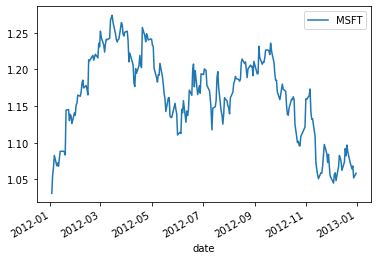

In [54]:
sample = "MSFT"
long = data[data.TICKER == sample]["RET"].rename(sample)
(1+long).cumprod().plot(legend=True)
plt.show()